### Process outline: 

Follow the scVI tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/harmonization.html

1. Do the preprocessing: use dandelion preprocessing package to filter out cell and gene outliers --> normalization and log transformation

2. Call scVI to integration

In [1]:
import os

import scanpy as sc
import scvi
import seaborn as sns
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker

import warnings
warnings.filterwarnings("ignore")

In [2]:
scvi.settings.seed = 0 # for reproducibility
print("Last run with scvi-tools version:", scvi.__version__)

[rank: 0] Seed set to 0


Last run with scvi-tools version: 1.1.2

In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=True)
sns.set_theme()
torch.set_float32_matmul_precision("high")

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [4]:
# Check if GPU is detected
device_count = torch.cuda.device_count()
device_count

1

In [5]:
print(torch.cuda.is_available())

True

In [6]:
# Load all AnnData objects into a list

from pathlib import Path
from itertools import chain

GSE132509_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE132509')
GSE236351_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE236351')
GSE148218_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE148218')

combined_dirs = chain(GSE132509_directory.iterdir(), GSE236351_directory.iterdir(), GSE148218_directory.iterdir())
adatas = []
for adata_path in combined_dirs:
    if "_uni.h5ad" in adata_path.name:
        adata = sc.read_h5ad(adata_path)
        adatas.append(adata)

print(len(adatas))
print(adatas[0])

26

AnnData object with n_obs × n_vars = 2229 × 33694
    obs: 'cancer_type', 'dataset', 'tissue', 'sample_barcode', 'uni_barcode'
    var: 'gene_ids'

In [7]:
# Find out common genes among all AnnData objects
common_genes = set(adatas[0].var_names)
for adata in adatas[1:]:
    common_genes.intersection_update(adata.var_names)

print(len(common_genes))

14071

In [8]:
# Filter all AnnData objects with common genes
adatas_common_genes = []
for adata in adatas:
    adata_common_genes = adata[:, list(common_genes)]
    # print(adata_common_genes.shape)
    adatas_common_genes.append(adata_common_genes)

### <span style="color:yellow">**Preprocessing:**</span> normalization & log transformation

Use the preprocessing package from dandelion to filter out cell and gene outliers

In [9]:
from dandelion.preprocessing.external._preprocessing import recipe_scanpy_qc

adatas_filtered = [] 

for adata in adatas_common_genes:
    adata.raw = adata

    # Do QC and filtering
    recipe_scanpy_qc(adata)
    adata = adata[adata.obs.filter_rna == 'False', :]

    # Do normalization
    sc.pp.normalize_total(adata)

    # Do the log transformation
    sc.pp.log1p(adata)

    adatas_filtered.append(adata)

In [10]:
# Create a merged AnnData for all filtered Anndata objects
adatas_filtered_all = sc.AnnData.concatenate(*adatas_filtered)

In [11]:
adatas_filtered_all

AnnData object with n_obs × n_vars = 85382 × 14071
    obs: 'cancer_type', 'dataset', 'tissue', 'sample_barcode', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-10', 'gene_ids-11', 'feature_types-11', 'gene_ids-12', 'feature_types-12', 'gene_ids-13', 'feature_types-13', 'gene_ids-14', 'feature_types-14', 'gene_ids-15', 'feature_types-15', 'gene_ids-16', 'feature_types-16', 'gene_ids-17', 'feature_types-17', 'gene_ids-18', 'feature_types-18', 'gene_ids-19', 'feature_types-19', 'gene_ids-2', 'gene_ids-20', 'feature_types-20', 'gene_ids-21', 'feature_types-21', 'gene_ids-22', 'feature_types-22', 'gene_ids-23', 'feature_types-23', 'gene_ids-24', 'feature_types-24', 'gene_ids-25', 'feature_types-25', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9'

In [12]:
# Select highly variable genes
sc.pp.highly_variable_genes(
    adatas_filtered_all,
    flavor="seurat_v3",
    n_top_genes=2000,
    batch_key="sample_barcode",
    subset=True,
)

In [13]:
adatas_filtered_all

AnnData object with n_obs × n_vars = 85382 × 2000
    obs: 'cancer_type', 'dataset', 'tissue', 'sample_barcode', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-10', 'gene_ids-11', 'feature_types-11', 'gene_ids-12', 'feature_types-12', 'gene_ids-13', 'feature_types-13', 'gene_ids-14', 'feature_types-14', 'gene_ids-15', 'feature_types-15', 'gene_ids-16', 'feature_types-16', 'gene_ids-17', 'feature_types-17', 'gene_ids-18', 'feature_types-18', 'gene_ids-19', 'feature_types-19', 'gene_ids-2', 'gene_ids-20', 'feature_types-20', 'gene_ids-21', 'feature_types-21', 'gene_ids-22', 'feature_types-22', 'gene_ids-23', 'feature_types-23', 'gene_ids-24', 'feature_types-24', 'gene_ids-25', 'feature_types-25', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9', 'highly_variab

In [14]:
# Visualize the data before integration
sc.tl.pca(adatas_filtered_all) # Calculate the PCA embeddings
sc.pp.neighbors(adatas_filtered_all) # Determine the kNN graph
sc.tl.umap(adatas_filtered_all) # Calculate the UMAP
sc.tl.leiden(adatas_filtered_all) # Cluster the cells

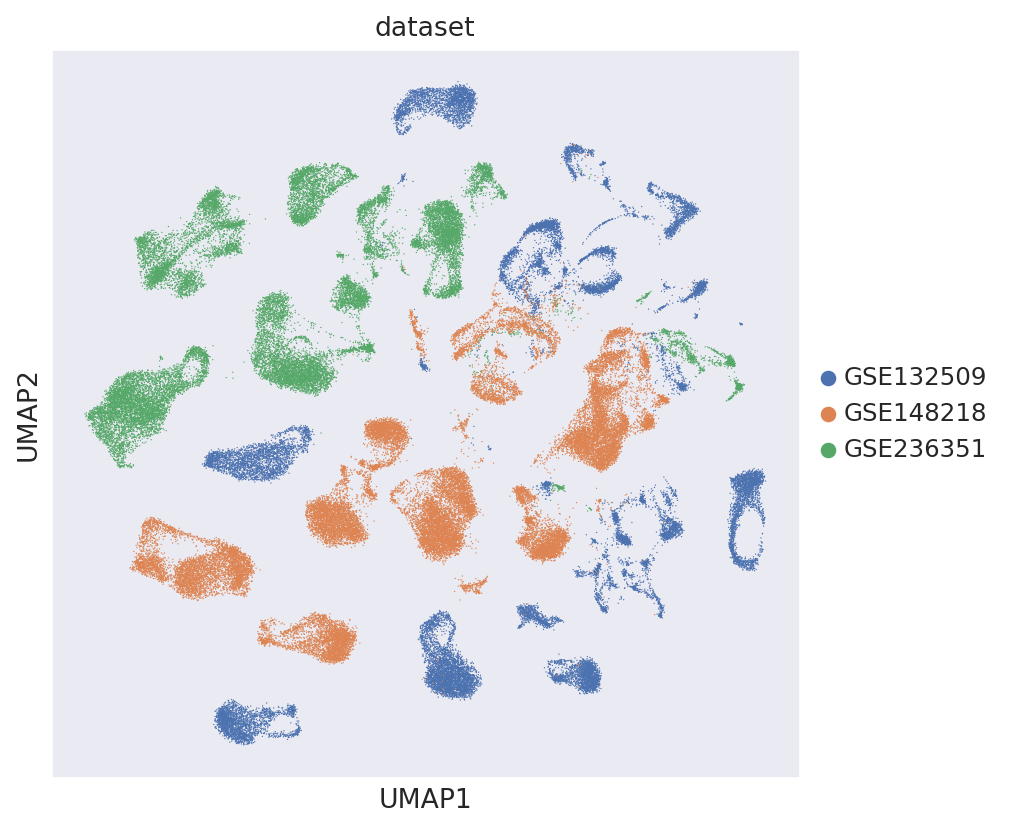

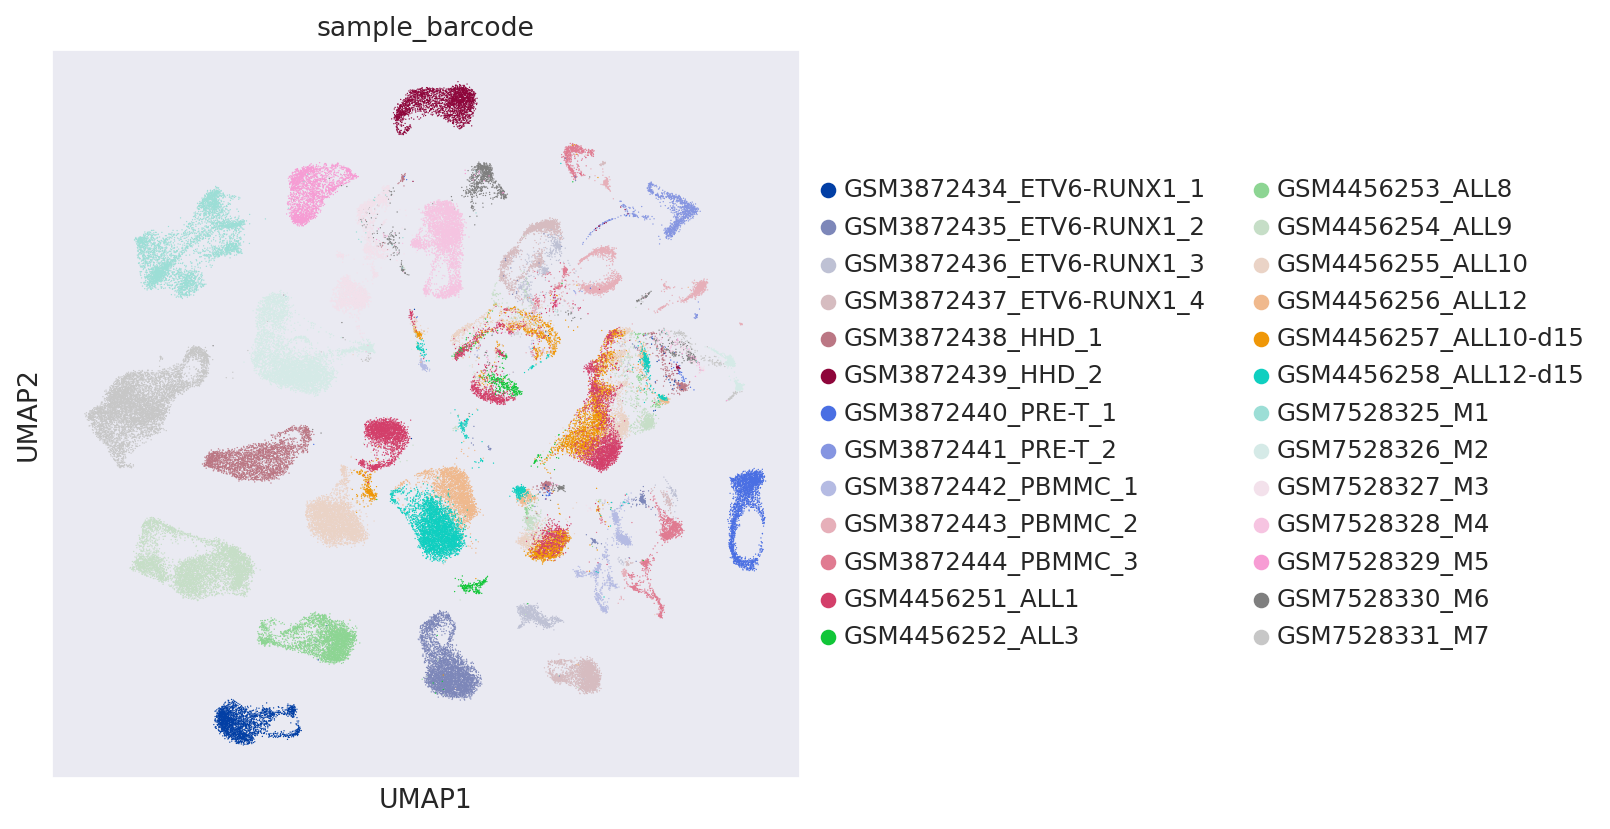

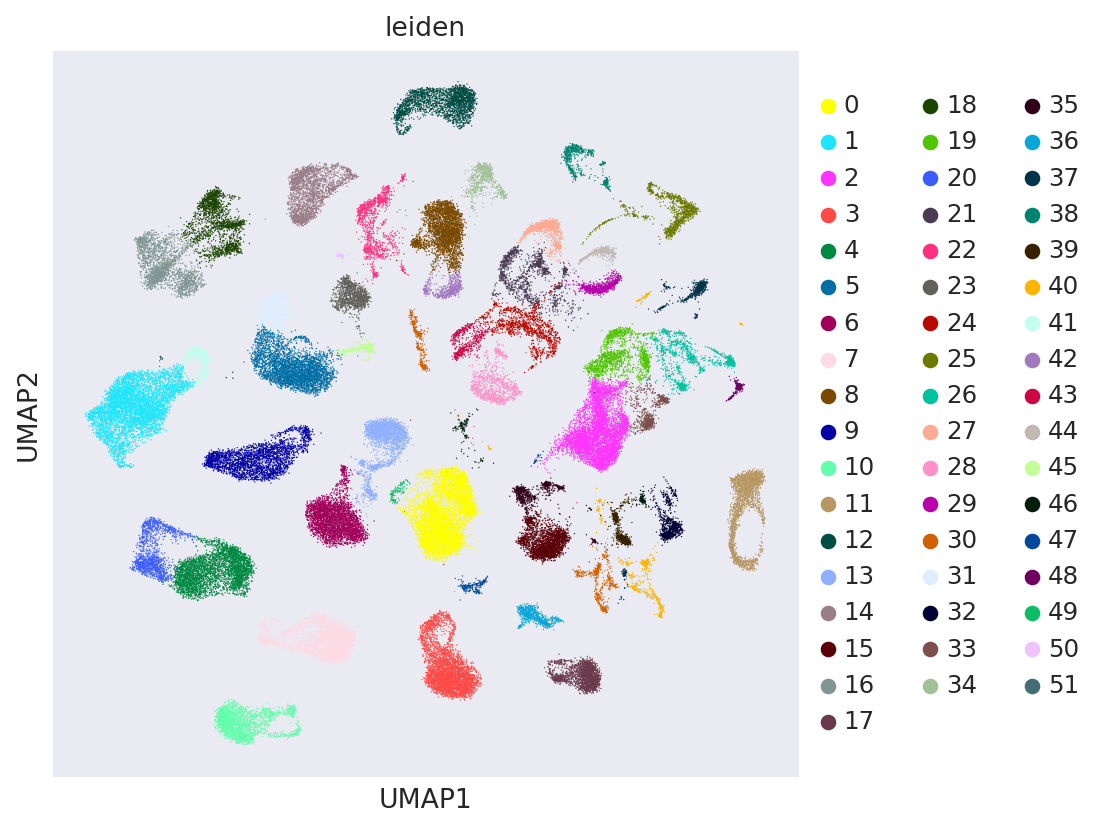

In [16]:
sc.pl.umap(adatas_filtered_all, color=['dataset'])
sc.pl.umap(adatas_filtered_all, color=['sample_barcode'])
sc.pl.umap(adatas_filtered_all, color=['leiden'])

### <span style="color:yellow">**Integration with scVI**</span> 

In [17]:
# Set up the scVI model
scvi.model.SCVI.setup_anndata(adatas_filtered_all, batch_key="sample_barcode")

In [18]:
# Set the parameters for scVI
model = scvi.model.SCVI(adatas_filtered_all, n_layers=2, n_latent=30, gene_likelihood="nb")

In [19]:
# Train the scVI model
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 94/94: 100%|████████████████████████████████████| 94/94 [05:03<00:00,  3.23s/it, v_num=1, train_loss_step=335, train_loss_epoch=328]

`Trainer.fit` stopped: `max_epochs=94` reached.


Epoch 94/94: 100%|████████████████████████████████████| 94/94 [05:03<00:00,  3.23s/it, v_num=1, train_loss_step=335, train_loss_epoch=328]


In [20]:
SCVI_LATENT_KEY = "X_scVI"
adatas_filtered_all.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [21]:
adatas_filtered_all

AnnData object with n_obs × n_vars = 85382 × 2000
    obs: 'cancer_type', 'dataset', 'tissue', 'sample_barcode', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch', 'leiden', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-10', 'gene_ids-11', 'feature_types-11', 'gene_ids-12', 'feature_types-12', 'gene_ids-13', 'feature_types-13', 'gene_ids-14', 'feature_types-14', 'gene_ids-15', 'feature_types-15', 'gene_ids-16', 'feature_types-16', 'gene_ids-17', 'feature_types-17', 'gene_ids-18', 'feature_types-18', 'gene_ids-19', 'feature_types-19', 'gene_ids-2', 'gene_ids-20', 'feature_types-20', 'gene_ids-21', 'feature_types-21', 'gene_ids-22', 'feature_types-22', 'gene_ids-23', 'feature_types-23', 'gene_ids-24', 'feature_types-24', 'gene_ids-25', 'feature_types-25', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', '

In [22]:
sc.pp.neighbors(adatas_filtered_all, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adatas_filtered_all)
sc.tl.umap(adatas_filtered_all)

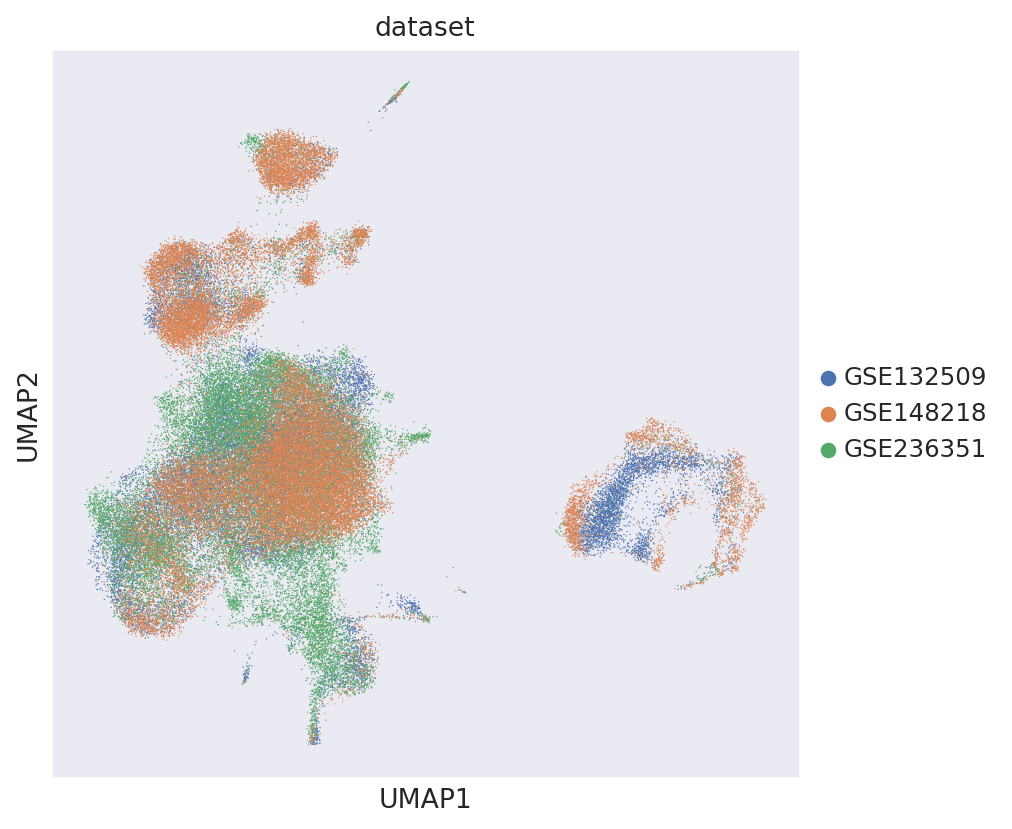

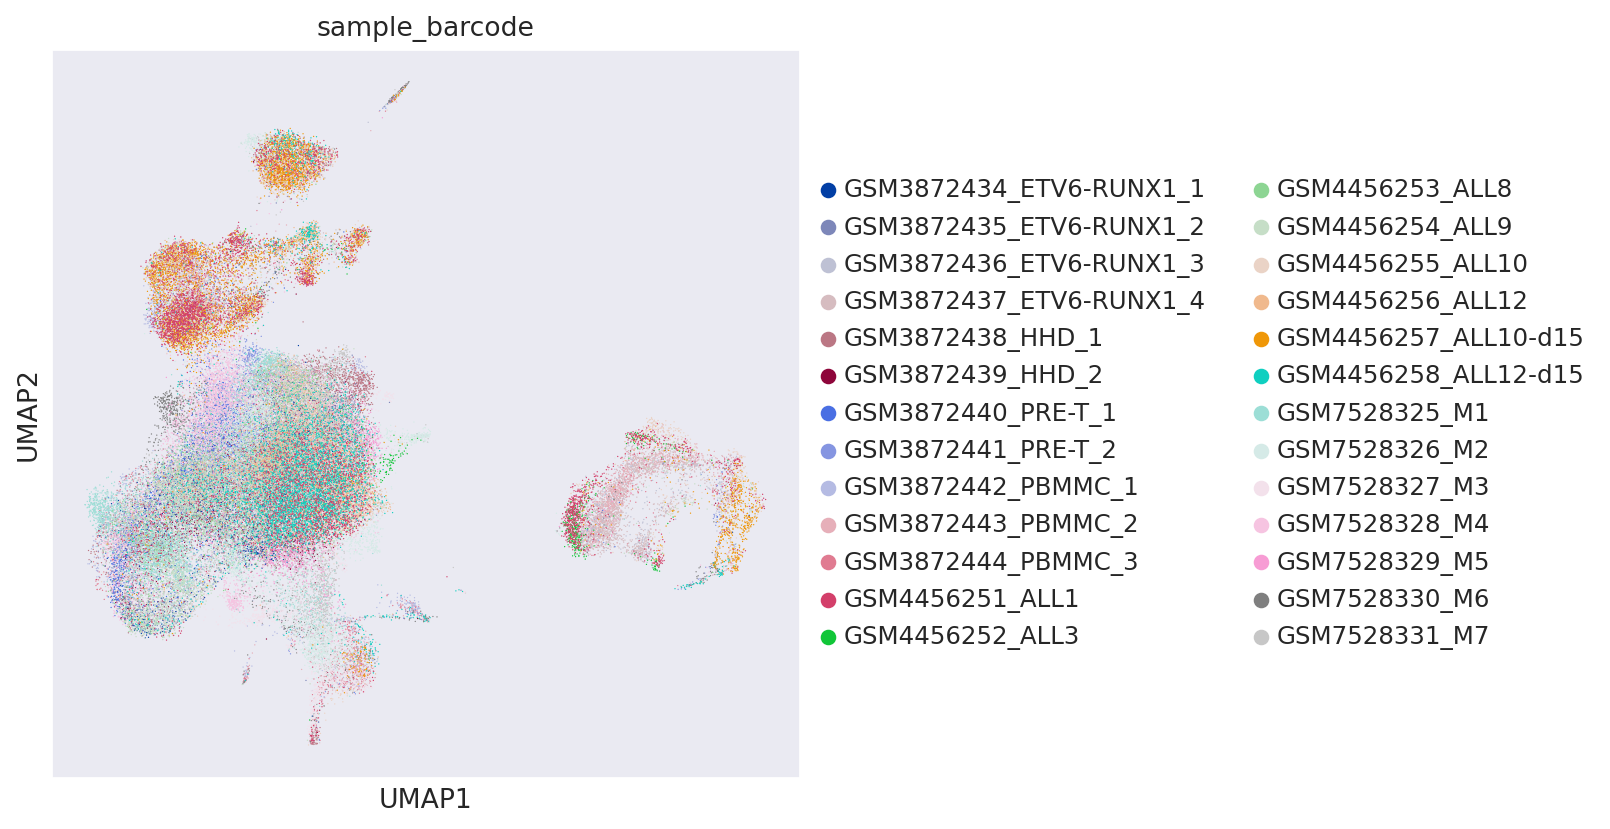

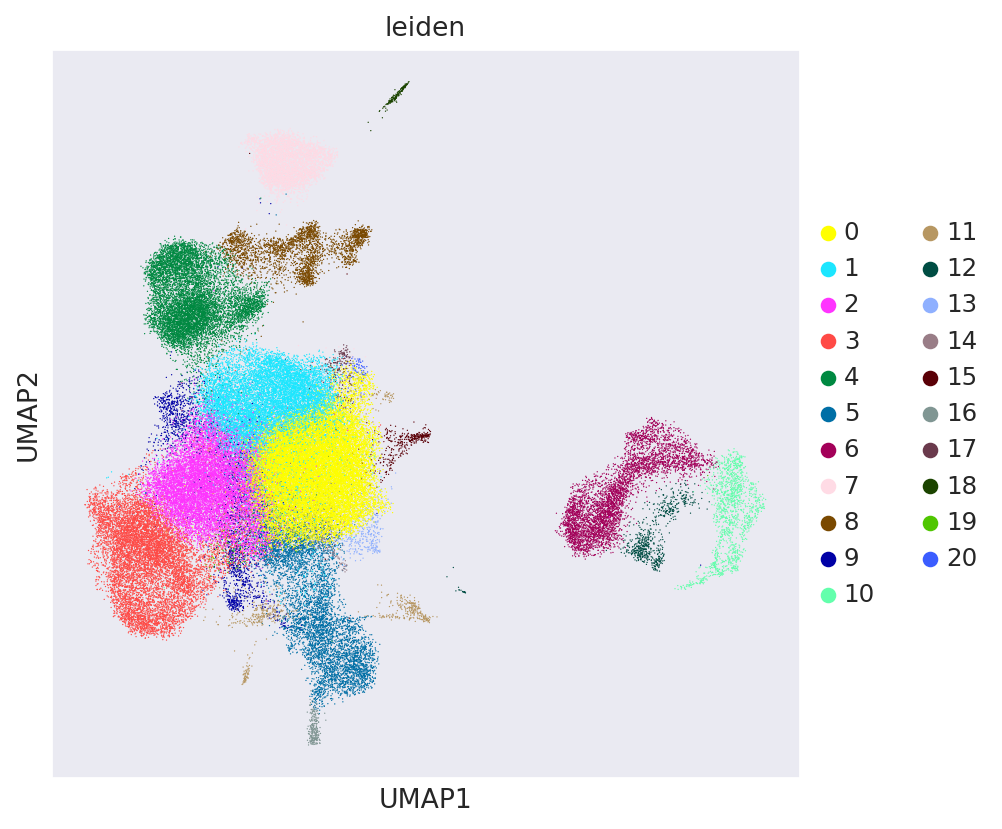

In [23]:
sc.pl.umap(adatas_filtered_all, color=['dataset'])
sc.pl.umap(adatas_filtered_all, color=['sample_barcode'])
sc.pl.umap(adatas_filtered_all, color=['leiden'])

<span style="color:red">Problem: </span> fail to use pymde for visualization

In [ ]:
# Try to use the pymde package, alternative to UMAP, for visualization of the integration outcomes 
SCVI_MDE_KEY = "X_scVI_MDE"
adatas_filtered_all.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adatas_filtered_all.obsm[SCVI_LATENT_KEY])